<a href="https://colab.research.google.com/github/NoobBeginnerReal/credit-risk-analysis/blob/main/Credit_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, log_loss

## INITIAL EDA

In [40]:
df = pd.read_csv("credit_risk_dataset.csv")

In [41]:
# Create an array of indices where employment length is greater than 60
indices = df[df['person_emp_length'] > 60].index
print(indices)
df_new = df.drop(indices, axis=0)

Index([0, 210], dtype='int64')


In [42]:
# Create the cross table from earlier and include minimum employment length
print(pd.crosstab(df_new['loan_status'],
                  df_new['person_home_ownership'],
                  values=df_new['person_emp_length'],
                  aggfunc=['min','max']))

                           min                                  max            \
person_home_ownership MORTGAGE    OTHER      OWN     RENT  MORTGAGE     OTHER   
loan_status                                                                     
0                     0.000000 0.000000 0.000000 0.000000 38.000000 24.000000   
1                     0.000000 0.000000 0.000000 0.000000 34.000000 11.000000   

                                           
person_home_ownership       OWN      RENT  
loan_status                                
0                     31.000000 41.000000  
1                     17.000000 27.000000  


# Handling missing

In [43]:
# Print an array of columns with null values
print(df.columns[df.isnull().any()])

Index(['person_emp_length', 'loan_int_rate'], dtype='object')


In [44]:
# Print the top five rows with nulls for employment length
print(df[df['person_emp_length'].isnull()].head())

# Replace the null values with the median value for all employment lengths
df['person_emp_length'].fillna((df['person_emp_length'].median()), inplace=True)

     person_age  person_income person_home_ownership  person_emp_length  \
105          22          12600              MORTGAGE                NaN   
222          24         185000              MORTGAGE                NaN   
379          24          16800              MORTGAGE                NaN   
407          25          52000                  RENT                NaN   
408          22          17352              MORTGAGE                NaN   

           loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
105           PERSONAL          A       2000       5.420000            1   
222          EDUCATION          B      35000      12.420000            0   
379  DEBTCONSOLIDATION          A       3900            NaN            1   
407           PERSONAL          B      24000      10.740000            1   
408          EDUCATION          C       2250      15.270000            0   

     loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
105        

<ipython-input-44-bb3788b9d7d7>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna((df['person_emp_length'].median()), inplace=True)


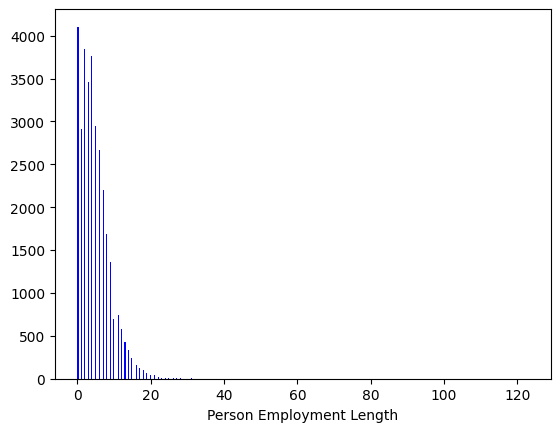

3116


,count
person_home_ownership,
RENT,16446
MORTGAGE,13444
OWN,2584
OTHER,107


In [45]:
# Create a histogram of employment length
n, bins, patches = plt.hist(df['person_emp_length'], bins='auto', color='blue')
plt.xlabel("Person Employment Length")
plt.show()
# Print the number of nulls
print(df['loan_int_rate'].isnull().sum())

# Store the array on indices
indices = df[df['loan_int_rate'].isnull()].index

# Save the new data without missing data
df_clean = df.drop(indices)
# Count the number of records for each unique value
df['person_home_ownership'].value_counts()

Encoding non numeric data

In [46]:
# Create two data sets for numeric and non-numeric data
cred_num = df_clean.select_dtypes(exclude=['object'])
cred_str = df_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
df_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print the columns in the new data set
print(df_prep.columns)

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')


In [47]:
df = df_prep

X = df.drop('loan_status', axis=1)
y = df['loan_status']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

xgb_model = XGBClassifier(use_label_encoder=False,
                          eval_metric='logloss',
                          random_state=42,
                          class_weight='balanced')
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:37:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "class_weight", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.93
Precision: 0.96
Recall: 0.74
F1 Score: 0.83
AUC: 0.95
Cross Entropy (Log Loss): 0.20
Specificity: 0.99
True Positives (TP): 1486
False Positives (FP): 66
True Negatives (TN): 6765
False Negatives (FN): 523


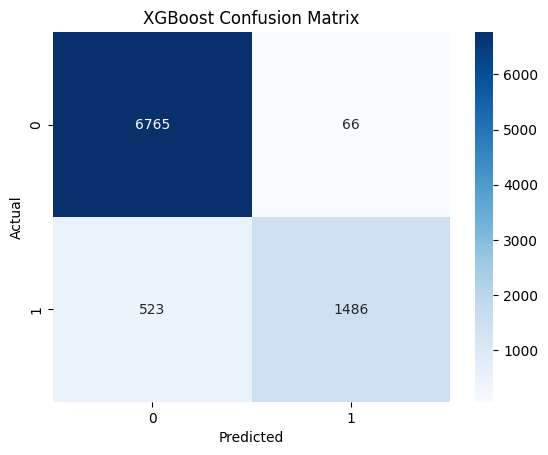

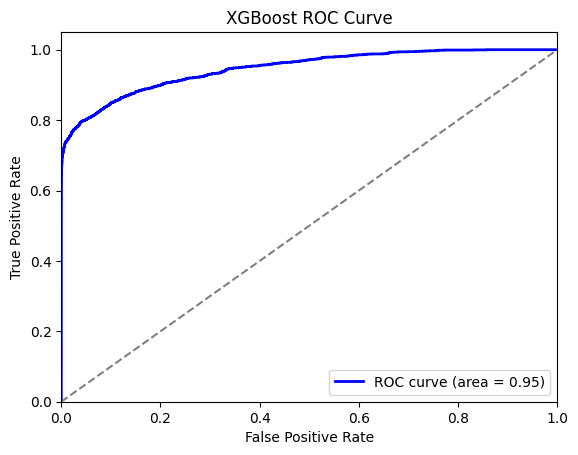

In [49]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)
cross_entropy = log_loss(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"AUC: {auc:.2f}")
print(f"Cross Entropy (Log Loss): {cross_entropy:.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

# Print confusion matrix values
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Plot Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.show()

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()


Top 10 Most Important Features (XGBoost):
                          Feature  Importance
10     person_home_ownership_RENT    0.231609
5             loan_percent_income    0.108324
19                   loan_grade_C    0.080327
11  loan_intent_DEBTCONSOLIDATION    0.066288
14            loan_intent_MEDICAL    0.064788
9       person_home_ownership_OWN    0.058855
4                   loan_int_rate    0.049974
20                   loan_grade_D    0.047934
13    loan_intent_HOMEIMPROVEMENT    0.043414
16            loan_intent_VENTURE    0.039048


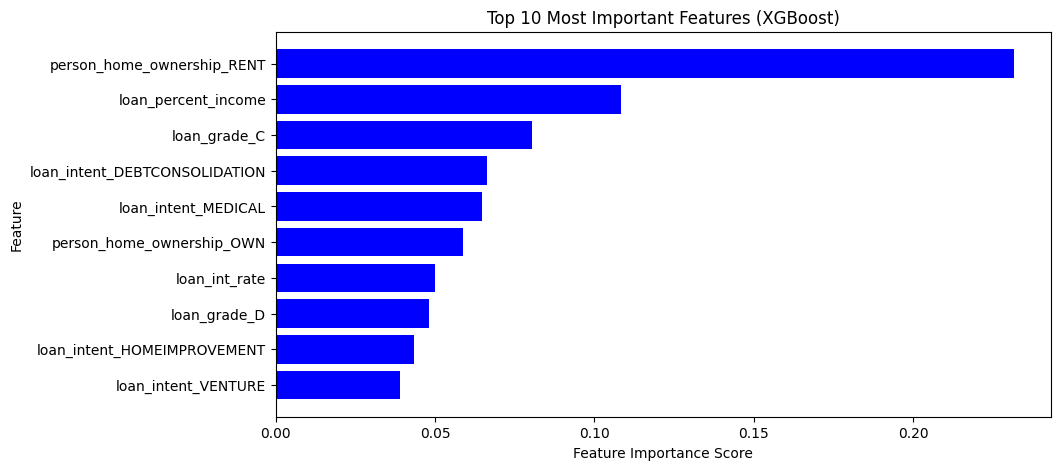

In [50]:
pd.options.display.float_format = '{:.6f}'.format
# Extract feature importance from XGBoost
feature_importance_xgb = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
})

# Sort features by importance
feature_importance_xgb = feature_importance_xgb.sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 5))
plt.barh(
    feature_importance_xgb['Feature'][:10],
    feature_importance_xgb['Importance'][:10],
    color='blue'
)
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Most Important Features (XGBoost)")

plt.show()

In [51]:
# Extract predicted probabilities from the trained model
test_pred_df = pd.DataFrame({
    'prob_default': xgb_model.predict_proba(X_test)[:, 1],  # Probability of default (XGBoost output)
    'true_loan_status': y_test.values,  # Actual loan outcome (0 = good, 1 = default)
    'loan_amnt': X_test['loan_amnt'].values
})

In [52]:
test_pred_df.head()

,prob_default,true_loan_status,loan_amnt
0,0.042639,0,17400
1,0.003691,0,3600
2,0.080315,0,9000
3,0.039501,0,1000
4,0.031523,0,5000


In [53]:
# Check statistics of probabilities of default
print("Default Probability Statistics:")
print(test_pred_df['prob_default'].describe())

# Calculate the threshold for an 85% acceptance rate
threshold_85 = np.quantile(test_pred_df['prob_default'], 0.85)

# Apply threshold: Loans with default probability below threshold are accepted (loan_status = 0)
test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > threshold_85 else 0)

# Check new loan status distribution
print("\nLoan Status Distribution After Applying 85% Acceptance Rate Threshold:")
print(test_pred_df['pred_loan_status'].value_counts())

Default Probability Statistics:
count   8840.000000
mean       0.222812
std        0.347648
min        0.000001
25%        0.009797
50%        0.050713
75%        0.202590
max        0.999999
Name: prob_default, dtype: float64

Loan Status Distribution After Applying 85% Acceptance Rate Threshold:
pred_loan_status
0    7514
1    1326
Name: count, dtype: int64


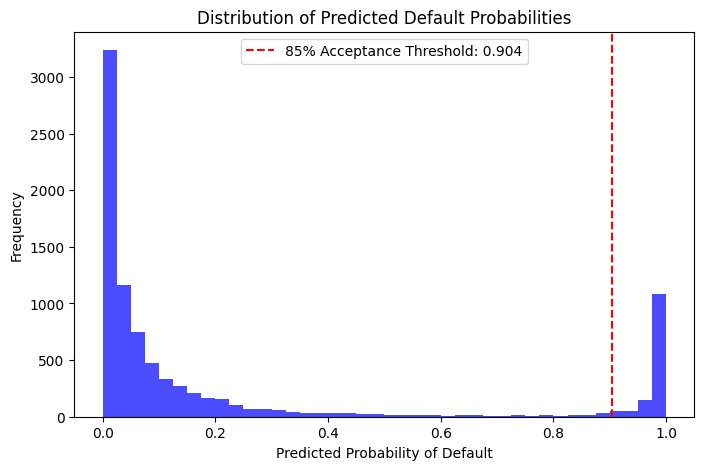

In [54]:
# Visualizing acceptance quantiles
plt.figure(figsize=(8,5))
plt.hist(test_pred_df['prob_default'], bins=40, color='blue', alpha=0.7)
plt.axvline(x=threshold_85, color='red', linestyle='dashed', label=f'85% Acceptance Threshold: {threshold_85:.3f}')
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Default Probabilities")
plt.legend()
plt.show()

In [55]:
# Print the top 5 rows of the new data frame
print(test_pred_df.head())

   prob_default  true_loan_status  loan_amnt  pred_loan_status
0      0.042639                 0      17400                 0
1      0.003691                 0       3600                 0
2      0.080315                 0       9000                 0
3      0.039501                 0       1000                 0
4      0.031523                 0       5000                 0


In [56]:
# Bad Rate Calculation
# Subset only accepted loans (pred_loan_status == 0)
accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]

# Compute the bad rate: % of accepted loans that defaulted
bad_rate = np.sum(accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])

print(f"\nBad Rate (Accepted Loans that Defaulted): {bad_rate:.2%}")


Bad Rate (Accepted Loans that Defaulted): 9.16%


In [57]:
# Print the statistics of the loan amount column
print(test_pred_df['loan_amnt'].describe())

count    8840.000000
mean     9552.539593
std      6265.100091
min       500.000000
25%      5000.000000
50%      8000.000000
75%     12000.000000
max     35000.000000
Name: loan_amnt, dtype: float64


In [58]:
# Impact of Acceptance Rates on Loan Amounts
print("\nLoan Amount Statistics:")
print(test_pred_df['loan_amnt'].describe())

# Compute average loan amount
avg_loan = np.mean(test_pred_df['loan_amnt'])

# Cross-tabulation of true vs predicted loan status impact
pd.options.display.float_format = '${:,.2f}'.format
impact_table = pd.crosstab(test_pred_df['true_loan_status'], test_pred_df['pred_loan_status']).apply(lambda x: x * avg_loan, axis=0)

print("\nImpact of Acceptance Rates on Total Loan Amounts:")
print(impact_table)


Loan Amount Statistics:
count    8840.000000
mean     9552.539593
std      6265.100091
min       500.000000
25%      5000.000000
50%      8000.000000
75%     12000.000000
max     35000.000000
Name: loan_amnt, dtype: float64

Impact of Acceptance Rates on Total Loan Amounts:
pred_loan_status              0              1
true_loan_status                              
0                $65,205,635.26     $47,762.70
1                 $6,572,147.24 $12,618,904.80


In [59]:
# Credit Strategy Table: Acceptance Rates, Thresholds, Bad Rates
pd.options.display.float_format = '{:.6f}'.format
accept_rates = [1.0, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]  # Acceptance rates to evaluate
thresholds, bad_rates = [], []

for rate in accept_rates:
    # Calculate threshold
    thresh = np.quantile(test_pred_df['prob_default'], rate).round(3)
    thresholds.append(thresh)

    # Assign new predicted loan status
    test_pred_df['pred_loan_status'] = test_pred_df['prob_default'].apply(lambda x: 1 if x > thresh else 0)

    # Compute bad rate for this threshold
    accepted_loans = test_pred_df[test_pred_df['pred_loan_status'] == 0]
    bad_rate = np.sum(accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])
    bad_rates.append(round(bad_rate, 3))

# Create strategy DataFrame
strat_df = pd.DataFrame(zip(accept_rates, thresholds, bad_rates), columns=['Acceptance Rate', 'Threshold', 'Bad Rate'])

print("\nCredit Strategy Table:")
print(strat_df)


Credit Strategy Table:
    Acceptance Rate  Threshold  Bad Rate
0          1.000000   1.000000  0.227000
1          0.950000   0.997000  0.184000
2          0.900000   0.988000  0.141000
3          0.850000   0.904000  0.092000
4          0.800000   0.331000  0.063000
5          0.750000   0.203000  0.052000
6          0.700000   0.146000  0.042000
7          0.650000   0.108000  0.036000
8          0.600000   0.082000  0.032000
9          0.550000   0.064000  0.028000
10         0.500000   0.051000  0.022000
11         0.450000   0.040000  0.020000
12         0.400000   0.031000  0.018000
13         0.350000   0.022000  0.013000
14         0.300000   0.016000  0.010000
15         0.250000   0.010000  0.006000
16         0.200000   0.005000  0.003000
17         0.150000   0.002000  0.002000
18         0.100000   0.001000  0.001000
19         0.050000   0.000000       NaN


<ipython-input-59-2551398321cd>:16: RuntimeWarning: invalid value encountered in scalar divide
  bad_rate = np.sum(accepted_loans['true_loan_status']) / len(accepted_loans['true_loan_status'])


<Axes: >

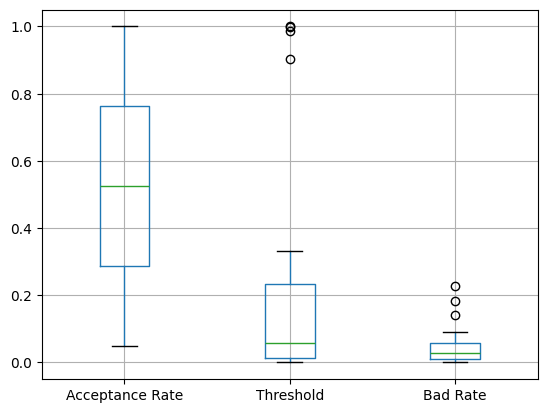

In [60]:
strat_df.boxplot()

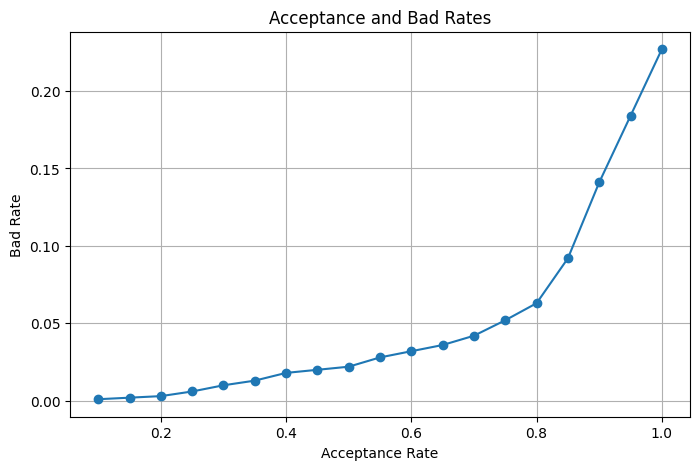

In [61]:
# 📌 7️⃣ Strategy Curve Visualization
plt.figure(figsize=(8,5))
plt.plot(strat_df['Acceptance Rate'], strat_df['Bad Rate'], marker='o', linestyle='-')
plt.xlabel('Acceptance Rate')
plt.ylabel('Bad Rate')
plt.title('Acceptance and Bad Rates')
plt.grid(True)
plt.show()

In [62]:
print(strat_df)

    Acceptance Rate  Threshold  Bad Rate
0          1.000000   1.000000  0.227000
1          0.950000   0.997000  0.184000
2          0.900000   0.988000  0.141000
3          0.850000   0.904000  0.092000
4          0.800000   0.331000  0.063000
5          0.750000   0.203000  0.052000
6          0.700000   0.146000  0.042000
7          0.650000   0.108000  0.036000
8          0.600000   0.082000  0.032000
9          0.550000   0.064000  0.028000
10         0.500000   0.051000  0.022000
11         0.450000   0.040000  0.020000
12         0.400000   0.031000  0.018000
13         0.350000   0.022000  0.013000
14         0.300000   0.016000  0.010000
15         0.250000   0.010000  0.006000
16         0.200000   0.005000  0.003000
17         0.150000   0.002000  0.002000
18         0.100000   0.001000  0.001000
19         0.050000   0.000000       NaN


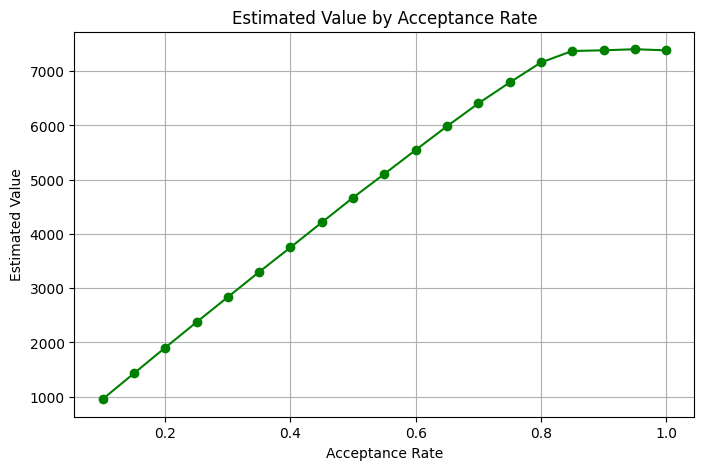

In [63]:
# Estimated Value Profiling
# (Assuming estimated value is computed using a function based on acceptance rate)
# You may need to define the actual function based on business rules
strat_df['Estimated Value'] = strat_df['Acceptance Rate'] * (1 - strat_df['Bad Rate']) * avg_loan

# Plot Estimated Value by Acceptance Rate
plt.figure(figsize=(8,5))
plt.plot(strat_df['Acceptance Rate'], strat_df['Estimated Value'], marker='o', linestyle='-', color='green')
plt.title('Estimated Value by Acceptance Rate')
plt.xlabel('Acceptance Rate')
plt.ylabel('Estimated Value')
plt.grid(True)
plt.show()


In [64]:
print(strat_df.loc[strat_df['Estimated Value'] == np.max(strat_df['Estimated Value'])])

   Acceptance Rate  Threshold  Bad Rate  Estimated Value
1         0.950000   0.997000  0.184000      7405.128692


In [65]:
# Assign LGD as 1 (100% loss in case of default)
test_pred_df['loss_given_default'] = 1.0

In [66]:
# Total Expected Loss Calculation
# Compute expected loss for each loan: Probability of Default * Loan Amount * Loss Given Default
test_pred_df['expected_loss'] = test_pred_df['prob_default'] * test_pred_df['loan_amnt'] * test_pred_df['loss_given_default']

# Compute total expected loss
total_expected_loss = round(np.sum(test_pred_df['expected_loss']), 2)

print(f"\nTotal Expected Loss (XGB): ${total_expected_loss:,.2f}")


Total Expected Loss (XGB): $21,016,055.63
